In [0]:
!wget 'https://storage.googleapis.com/kaggle-data-sets/40205/63131/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1577774585&Signature=Qe6kmPJJmKGDcSRkueP%2F1fFAOpch18bhcn9v6I2evHkJcvk2RInp%2BYEL6YG4N3s8ze3o7WeSbPXlYydEIILPI6VWs6X5RxOR0lAZir%2FGFajtEjV6BlhE%2FkNBNQ4qwewHXt4Ve9HVpIRDfjutv0Xe59N1VJJneSNHCXroEhs0c%2BstLqWFlBayU6zaLniVEdYiSFqqSdKooPI3qcSzGQ4UQBwDiWMY2gC5r4tp%2BHnf3qQ6k%2Ft2qqfLJf%2FZcWAg8%2Fhl33Ndtq5k80c53EkjROcK%2FbOsUjyr5pEDAKukDnN2op9LNpciVs3IRy9PqSxcaTggR5cay%2Fzyhc4Q2akeIxCslQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dpokemon-generation-one.zip'

The name is too long, 540 chars total.
Trying to shorten...
New name is archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1577774585&Signature=Qe6kmPJJmKGDcSRkueP%2F1fFAOpch18bhcn9v6I2evHkJcvk2RInp+YEL6YG4N3s8ze3o7WeSbPXlYydEIILPI6VWs6X5RxOR0lAZir%2FGFajtEjV6BlhE%2FkNBNQ4qwew.
--2019-12-28 18:11:23--  https://storage.googleapis.com/kaggle-data-sets/40205/63131/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1577774585&Signature=Qe6kmPJJmKGDcSRkueP%2F1fFAOpch18bhcn9v6I2evHkJcvk2RInp%2BYEL6YG4N3s8ze3o7WeSbPXlYydEIILPI6VWs6X5RxOR0lAZir%2FGFajtEjV6BlhE%2FkNBNQ4qwewHXt4Ve9HVpIRDfjutv0Xe59N1VJJneSNHCXroEhs0c%2BstLqWFlBayU6zaLniVEdYiSFqqSdKooPI3qcSzGQ4UQBwDiWMY2gC5r4tp%2BHnf3qQ6k%2Ft2qqfLJf%2FZcWAg8%2Fhl33Ndtq5k80c53EkjROcK%2FbOsUjyr5pEDAKukDnN2op9LNpciVs3IRy9PqSxcaTggR5cay%2Fzyhc4Q2akeIxCslQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dpokemon-generation-one.zip
Resolving storage.googleapis.com (storage.g

In [0]:
!mv *archive* pokemon.zip

In [0]:
!unzip pokemon.zip

In [0]:
!rm -rf dataset/dataset

In [0]:
!pip install mahotas

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for mahotas: filename=mahotas-1.4.9-cp36-cp36m-linux_x86_64.whl size=4263998 sha256=4a831fcc5096dcbd256016afcf557ddcfc0dd3c411375da23b6b4a84c10fd565
  Stored in directory: /root/.cache/pip/wheels/02/e7/50/b67eee3b19c479cc5b41f10230bf9c1556be6eaaf095c6e997
Successfully built mahotas


In [0]:
import numpy as np
import pickle
import os
from PIL import Image
import cv2
import mahotas
import h5py
import time
import warnings
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

from skimage.feature import hog

import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
#Const
SEED = 42
np.random.seed(SEED)
DATAROOT = 'dataset'
CATEGORIES = 'categories.pkl'
TRAIN_IMAGES = 'train_images.pkl'
TRAIN_LABELS = 'train_labels.pkl'
TEST_IMAGES = 'test_images.pkl'
TEST_LABELS = 'test_labels.pkl'
h5_train_images_g = 'train_images_g.h5'
h5_train_labels_g = 'train_labels_g.h5'
h5_test_images_g = 'test_images_g.h5'
h5_test_labels_g = 'test_labels_g.h5'
NUM_CLASSES = 5 # number of classes used for training and testing
bins = 8
test_size = 0.2
num_trees = 100
scoring = 'accuracy'

In [0]:
def labeling():
    images = []
    labels = []

    classes_name = os.listdir(DATAROOT)
    classes_dict = {(class_name, len(os.listdir(os.path.join(DATAROOT, class_name)))) for class_name in classes_name}
    classes_dict = sorted(classes_dict, key = lambda x: -x[1])
    classes_name = [class_name[0] for class_name in classes_dict]

    for label, class_name in tqdm(enumerate(classes_name)):
        imgs_path = os.listdir(os.path.join(DATAROOT, class_name))
        for img_path in imgs_path:
            if img_path.endswith('.svg'):
                continue
            full_path = os.path.join(DATAROOT, class_name, img_path)
            img = cv2.imread(full_path)
            if img is None:
                print(full_path)
                continue
            
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
            
            img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)
            images.append(img)
            labels.append(label)
        
    images = np.array(images)
    labels = np.array(labels)

    Xtrain, Xtest, ytrain, ytest = train_test_split(images, labels, test_size=test_size, random_state=SEED)

    pickle.dump(classes_name, open(CATEGORIES, 'wb'))
    pickle.dump(Xtrain, open(TRAIN_IMAGES, 'wb'))
    pickle.dump(ytrain, open(TRAIN_LABELS, 'wb'))
    pickle.dump(Xtest, open(TEST_IMAGES, 'wb'))
    pickle.dump(ytest, open(TEST_LABELS, 'wb'))

            
labeling()

59it [01:00,  1.88it/s]

dataset/Voltorb/94f443d834f94c1e8e6b088d879646d4.gif~c200


118it [01:29,  2.21it/s]

dataset/Venonat/56425d5f66e64584afbfc797b93c7ee5.ico


149it [01:47,  2.56it/s]


In [0]:
def load_data(load_train=True, num_classes=NUM_CLASSES):
    categories = pickle.load(open(CATEGORIES, 'rb'))
    if load_train:
        images = pickle.load(open(TRAIN_IMAGES, 'rb'))
        labels = pickle.load(open(TRAIN_LABELS, 'rb'))
    else:
        images = pickle.load(open(TEST_IMAGES, 'rb'))
        labels = pickle.load(open(TEST_LABELS, 'rb'))

    if num_classes > 0:
        choices = labels < num_classes
        images = images[choices]
        labels = labels[choices]
        categories = categories[:num_classes]
    #plt.imshow(images[0])
    #plt.show()
    
    return images, labels, categories

In [0]:
Xtrain, ytrain, categories = load_data(load_train=True)
Xtest, ytest, _ = load_data(load_train=False)

In [0]:
categories

['Mewtwo', 'Pikachu', 'Charmander', 'Bulbasaur', 'Squirtle']

In [0]:
def show_img(img = None, algo = None, label = None):
  t = categories[label]
  if algo: t = algo+'->'+t
  plt.title(t)
  plt.imshow(img)
  plt.show()

(1177, 224, 224, 3)
(292, 224, 224, 3)


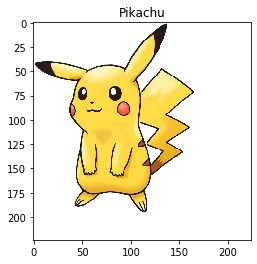

In [0]:
print(Xtrain.shape)
print(Xtest.shape)
show_img(Xtest[1], None, ytest[1])

In [0]:
#Global features extraction
def hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def histogram(image, mask=None):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def hogg(image):
    feature, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    return feature

In [0]:
#Global features extraction
def global_features(dataset):
  g_features = []
  for img in dataset:
    hu_moments_features = hu_moments(img)
    haralick_features = haralick(img)
    histogram_features = histogram(img)
    hog_features = hogg(img)
    g_feature = np.hstack([histogram_features, haralick_features, hu_moments_features, hog_features])
    g_features.append(g_feature)
  return g_features

In [0]:
#Global features extraction
g_features_train = global_features(Xtrain)
g_features_test = global_features(Xtest)

In [0]:
#Save features
def save_features(features, labels, h5_images, h5_labels):
  # encode the target labels
  targetNames = np.unique(labels)
  le          = LabelEncoder()
  target      = le.fit_transform(labels)

  # scale features in the range (0-1)
  scaler            = MinMaxScaler(feature_range=(0, 1))
  rescaled_features = scaler.fit_transform(features)

  # save the feature vector using HDF5
  h5f_image = h5py.File(h5_images, 'w')
  h5f_image.create_dataset('dataset', data=np.array(rescaled_features))

  h5f_label = h5py.File(h5_labels, 'w')
  h5f_label.create_dataset('dataset', data=np.array(target))

  h5f_image.close()
  h5f_label.close()

In [0]:
#Save features
save_features(g_features_train, ytrain, h5_train_images_g, h5_train_labels_g)
save_features(g_features_test, ytest, h5_test_images_g, h5_test_labels_g)

In [0]:
#Train and test
models = []
models.append(('LR', LogisticRegression(random_state=SEED)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=NUM_CLASSES+2)))
models.append(('DT', DecisionTreeClassifier(random_state=SEED)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=SEED)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=SEED)))
models.append(('SGD', SGDClassifier(loss='modified_huber', shuffle=True, random_state=SEED)))

h5f_image_train = h5py.File(h5_train_images_g, 'r')
h5f_label_train = h5py.File(h5_train_labels_g, 'r')
h5f_image_test = h5py.File(h5_test_images_g, 'r')
h5f_label_test = h5py.File(h5_test_labels_g, 'r')

train_image =  np.array(h5f_image_train['dataset'])
train_label = np.array(h5f_label_train['dataset'])
test_image = np.array(h5f_image_test['dataset'])
test_label = np.array(h5f_label_test['dataset'])

h5f_image_train.close()
h5f_label_train.close()
h5f_image_test.close()
h5f_label_test.close()

In [0]:
print(train_image.shape)

(1177, 2100)


In [0]:
#Train and test
algos = []
preds = []
accrs = []
for algo, model in models:
  model.fit(train_image, train_label)
  pred = model.predict(test_image)
  accr = accuracy_score(pred, test_label)
  algos.append(algo)
  preds.append(pred)
  accrs.append(accr)
  print(algo, accr)

LR 0.6643835616438356
LDA 0.4520547945205479
KNN 0.4452054794520548
DT 0.6335616438356164
RF 0.8356164383561644
NB 0.3527397260273973
SVM 0.4349315068493151
SGD 0.6952054794520548


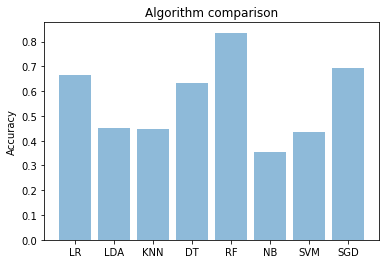

In [0]:
plt.bar(np.arange(len(algos)), accrs, align='center', alpha=0.5)
plt.xticks(np.arange(len(algos)), algos)
plt.ylabel('Accuracy')
plt.title('Algorithm comparison')
plt.show()

116
Squirtle


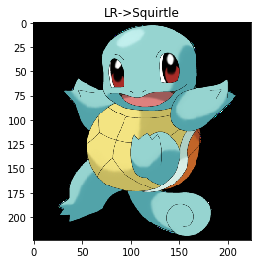

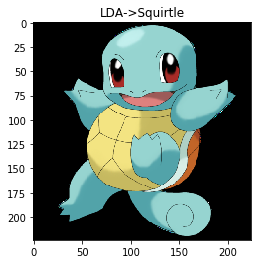

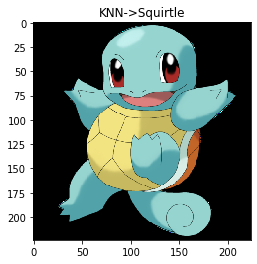

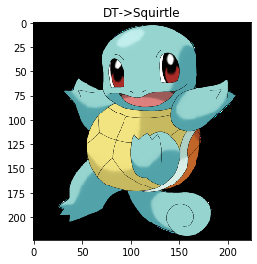

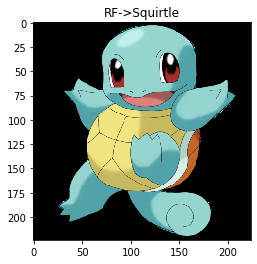

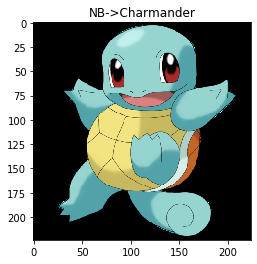

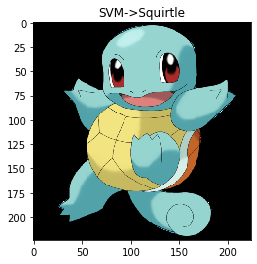

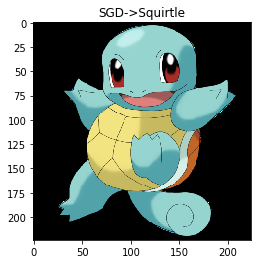

7 / 8


In [0]:
#Random sample
import secrets
secretsGenerator = secrets.SystemRandom()
a = list(range(0,len(Xtest)))
c = secretsGenerator.choice(a)
print(c)
print(categories[ytest[c]])
cnt = 0
for i in range(len(preds)):
  #print(preds[i][c])
  show_img(Xtest[c], algos[i], preds[i][c])
  if ytest[c]==preds[i][c]: cnt += 1
print(cnt, '/', len(preds))